# Аналитика онлайн-продаж (Самокат)

В этом ноутбуке проводится анализ продаж товаров по данным из таблиц "products" и "orders".

**Цель** — выполнить набор аналитических задач: определить ходовые категории, изучить структуру продаж, рассчитать средний чек, промо-долю, маржу и провести ABC-анализ.

Импортируем необходимые для анализа библиотеки и настраиваем отображение графиков.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Отображение всех колонок в pandas
pd.set_option('display.max_columns', None)

## **ШАГ 1**: Загружаем таблицы products и orders. Проводим первичный обзор имеющихся данных.

Задачи:
1. Загрузить таблицы products и orders
2. Привести типы данных, при необходимости
3. Проверить пропуски и дубликаты
4. Добавить поля, необходимые для дальнейшего анализа

In [11]:
# Пути к файлам
path_products = '../data/products.xlsx'
path_orders = '../data/orders.xlsx'

In [12]:
# Загрузка данных из Excel для products
products = pd.read_excel(path_products, engine='openpyxl')

In [13]:
products.head()

,product_id,level1,level2,name
0,1,Гигиена,Бритье,Кассеты для бритья Gillette Fusion ProGlide Po...
1,2,Мучные кондитерские изделия,Мучные кондитерские изделия,Печенье Бодрость
2,3,Мясная гастрономия,"Сосиски, сардельки",Сосиски Стародворье
3,4,Чай,Черный чай,Чай Азерчай
4,5,Безалкогольные напитки,Соковая продукция,Морс Valio


In [27]:
# Загрузка данных из Excel для orders
orders = pd.read_excel(path_orders, engine='openpyxl')

In [16]:
orders.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130


In [19]:
# Проверяем размеры и типы данных для products
print("Products shape:", products.shape)
print("\nProducts dtypes:")
print(products.dtypes)

Products shape: (40152, 4)

Products dtypes:
product_id     int64
level1        object
level2        object
name          object
dtype: object


In [20]:
# Проверяем размеры и типы данных для orders
print("Orders shape:", orders.shape)
print("\nOrders dtypes:")
print(orders.dtypes)

Orders shape: (3323, 7)

Orders dtypes:
order_id                  int64
accepted_at      datetime64[ns]
product_id                int64
quantity                  int64
regular_price             int64
price                     int64
cost_price                int64
dtype: object


In [30]:
# Создаём вспомогательные поля
orders['sales_qty'] = orders['quantity']
orders['sales_sum'] = orders['price'] * orders['quantity']


In [31]:
# Добавляем признак промо
orders['is_promo'] = orders['price'] != orders['regular_price']

orders.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,1,169,False
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,1,169,False
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,1,169,False
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False


In [25]:
# Проверяем пропуски
print("Пропуски в products:")
print(products.isna().sum())

print("\nПропуски в orders:")
print(orders.isna().sum())

Пропуски в products:
product_id      0
level1          0
level2          0
name          212
dtype: int64

Пропуски в orders:
order_id         0
accepted_at      0
product_id       0
quantity         0
regular_price    0
price            0
cost_price       0
sales_qty        0
sales_sum        0
is_promo         0
dtype: int64


In [26]:
# Проверяем дубликаты
print("\nДубликаты:")
print("products duplicates:", products.duplicated().sum())
print("orders duplicates:", orders.duplicated().sum())


Дубликаты:
products duplicates: 0
orders duplicates: 0


### Результаты шага:
* данные успешно загружены
* добавлены технические поля
    * sales_qty — количество
    * sales_sum — сумма продажи
    * is_promo — признак промо
* проверены пропуски и дубликаты

## **ШАГ 2**: Объединяем таблицы product и orders

Задачи:
1. Объединить таблицы orders и products
2. Убрать заказы с товарами, которых нет в products (кроме среднего чека)
3. Проверить, сколько строк потерялось
4. Подготовить итоговый датафрейм df, с которым будем работать дальше

In [32]:
# Объединяем таблицы: orders + products
df = orders.merge(products, on='product_id', how='left')

df.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo,level1,level2,name
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат


In [34]:
# Проверяем, что все колонки на месте, включая ранее добавленные
df.columns

Index(['order_id', 'accepted_at', 'product_id', 'quantity', 'regular_price',
       'price', 'cost_price', 'sales_qty', 'sales_sum', 'is_promo', 'level1',
       'level2', 'name'],
      dtype='object')

In [35]:
# Проверяем, сколько товаров не нашлось в products
missing_products = df['level1'].isna().sum()
missing_products

np.int64(305)

In [36]:
# Фильтруем строки, где есть категория товара (для анализа категорий)
df = df[~df['level1'].isna()].copy()

df.shape

(3018, 13)

In [37]:
df[['product_id', 'level1', 'level2', 'sales_qty', 'sales_sum']].head()

,product_id,level1,level2,sales_qty,sales_sum
0,17122,Рыбная гастрономия,Нерыбные продукты моря,1,169
1,17122,Рыбная гастрономия,Нерыбные продукты моря,1,169
2,17122,Рыбная гастрономия,Нерыбные продукты моря,1,169
3,22199,Сыры,Мягкие сыры,1,219
4,22199,Сыры,Мягкие сыры,1,219


### Результаты шага:
* таблицы orders и products объединены
* все строки заказов сопоставлены с категориями товаров
* строки с отсутствующими категориями удалены (создан отдельный dataframe)

## **ШАГ 3**: Выделяем самую ходовую товарную группу

Задачи:
1. Посчитать количество проданных штук по каждой категории level1
2. Вывести таблицу
3. Найти категорию-лидера
4. Построить читаемый bar-chart

In [39]:
# Группировка по категориям: сколько штук продано по каждой категории
category_sales = df.groupby('level1')['sales_qty'].sum().reset_index()

category_sales

,level1,sales_qty
0,Бакалея,239
1,Безалкогольные напитки,534
2,Бытовая химия,23
3,Гигиена,77
4,Детское питание,96
5,Детство (Гигиена и Уход),6
6,Замороженная продукция,175
7,Кондитерские изделия,138
8,Консервированные продукты,74
9,"Кофе, какао",21


In [40]:
# Сортируем полученный результат по количеству продаж
category_sales_sorted = category_sales.sort_values(by='sales_qty', ascending=False)
category_sales_sorted

,level1,sales_qty
1,Безалкогольные напитки,534
11,Молочная продукция,483
19,Свежие овощи,262
10,Кулинария,250
0,Бакалея,239
25,Хлеб и хлебобулочные изделия,218
21,Снэки,212
20,Свежие фрукты,184
6,Замороженная продукция,175
7,Кондитерские изделия,138


In [42]:
# Находим категорию-лидера, которая продавалась лучше всех
top_category = category_sales_sorted.iloc[0]
top_category

level1       Безалкогольные напитки
sales_qty                       534
Name: 1, dtype: object

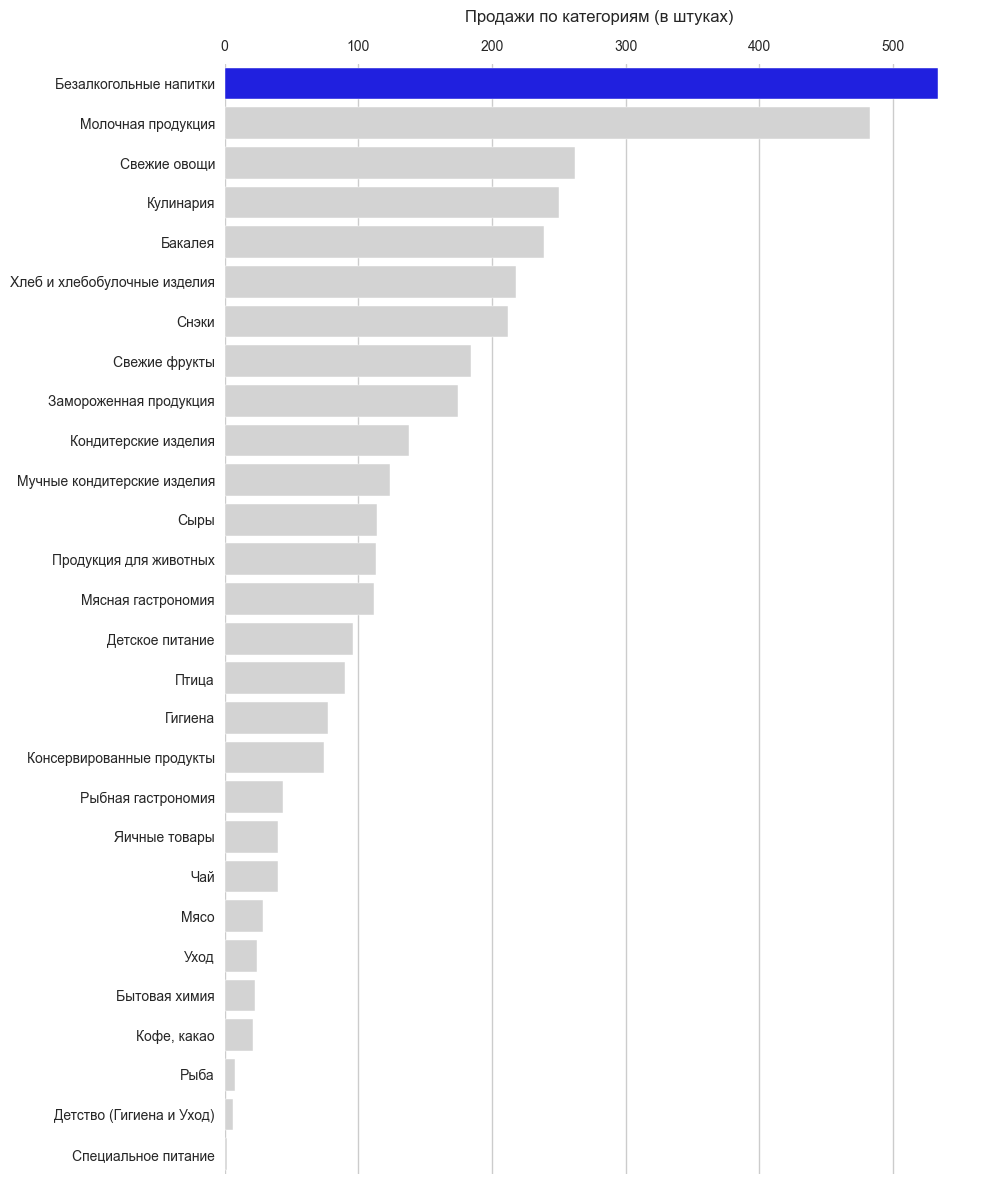

In [70]:
# 1. Находим категорию с максимальными продажами
max_category = category_sales_sorted.iloc[0]['level1']

# 2. Создаём цвета: максимальная категория — синий, остальные — серые
colors = [
    'blue' if cat == max_category else 'lightgray'
    for cat in category_sales_sorted['level1']
]

# 3. Преобразуем в словарь {категория: цвет}, чтобы не было FutureWarning
palette = dict(zip(category_sales_sorted['level1'], colors))

# 4. Строим график
plt.figure(figsize=(10, 12))
ax = sns.barplot(
    data=category_sales_sorted,
    y='level1',
    x='sales_qty',
    hue='level1',
    palette=palette,
    legend=False
)

# --- переносим ось X наверх ---
ax.xaxis.set_label_position('top')   # подпись оси X наверху
ax.xaxis.tick_top()                  # значения оси X наверху

# --- убираем названия осей ---
ax.set_xlabel('')
ax.set_ylabel('')

# --- заголовок ---
plt.title('Продажи по категориям (в штуках)', pad=30)

plt.tight_layout()
plt.show()



### Результаты шага:
* Наиболее ходовая категория - безалкогольные напитки
* Таблица показывает распределение количества проданных штук по всем категориям
* Barchart визуально подтверждает, что категория-лидер выделяется среди остальных

## **ШАГ 4**: Строим распределение продаж по подкатегориям

Задачи:
1. Посчитать, сколько штук продано в каждой подкатегории (level2) внутри каждой категории (level1).
2. Получить таблицу, по которой видно структуру продаж.

In [87]:
# 1. Группировка: продажи по категориям и подкатегориям
subcategory_sales = (
    df.groupby(['level1', 'level2'])['sales_qty']
      .sum()
      .reset_index()
)

# 2. Сортировка по количеству продаж
subcategory_sales_sorted = (
    subcategory_sales
    .sort_values(by='sales_qty', ascending=False)
)

# 3. Вывод таблицы
pd.set_option('display.max_rows', None)
subcategory_sales_sorted.head(10)

,level1,level2,sales_qty
13,Безалкогольные напитки,Напитки,252
54,Кулинария,Готовые блюда,248
95,Хлеб и хлебобулочные изделия,Хлеб и хлебобулочные изделия,218
86,Снэки,Снэки соленые,180
12,Безалкогольные напитки,Воды питьевые,162
78,Свежие овощи,"Корнеплоды, зелень и прочие овощи",157
60,Молочная продукция,Молоко и сливки,147
61,Молочная продукция,Молочно-десертные продукты,116
81,Свежие фрукты,"Цитрусовые, семечковые и прочие плоды",108
57,Молочная продукция,Кисломолочные традиционные продукты,106


### Результаты шага:
* Наибольший объём продаж в штуках пришёлся на подкатегории «Напитки», «Готовые блюда», «Хлебобулочные изделия» и «Снэки».
* В категории "Безалкогольные напитки" основную долю продаж дает подкатегория "Напитки"

## **ШАГ 5**: Считаем средний чек на дату 13.01.2022

Задача:
1. Определить, сколько в среднем тратил покупатель в указанный день

In [88]:
# Фильтр по дате 13 января 2022 года
date_filter = "2022-01-13"

orders_13 = orders[orders['accepted_at'].dt.date == pd.to_datetime(date_filter).date()]

orders_13.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,1,169,False
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,1,169,False
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,1,169,False
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False


In [89]:
# Сумма чека = сумма продаж в рамках order_id
order_sums = orders_13.groupby('order_id')['sales_sum'].sum().reset_index()

order_sums.head()


,order_id,sales_sum
0,1517207363,795
1,1517288545,364
2,1517293568,1715
3,1517302077,2096
4,1517305540,342


In [91]:
# Считаем средний чек
average_check = order_sums['sales_sum'].mean()
print(f"Средний чек 13.01.2022: {average_check:.2f} ₽")

Средний чек 13.01.2022: 915.64 ₽


### Результаты шага:
* Средний чек составил 915.64 ₽
* Это средний объём расходов одного покупателя в выбранную дату.